## Import libraries and data

In [1]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

In [4]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


We have 60000 images 28x28 pixels for training and 10000 images for testing

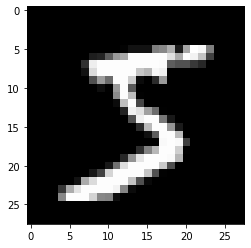

In [5]:
# Plot image data from x_train for checking that data is uploaded
plt.imshow(x_train[0], cmap = "gray")
plt.show()

## Add noise
Add noise with normal distribution N(0, 1) to training and testing datasets and plot several original and noisy images 

In [6]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [7]:
def plot_numbers(*x):
    k = len(x)
    n = 10  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        for j in range(k):
            ax = plt.subplot(k, n, i + 1 + n * j)
            plt.imshow(x[j][i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

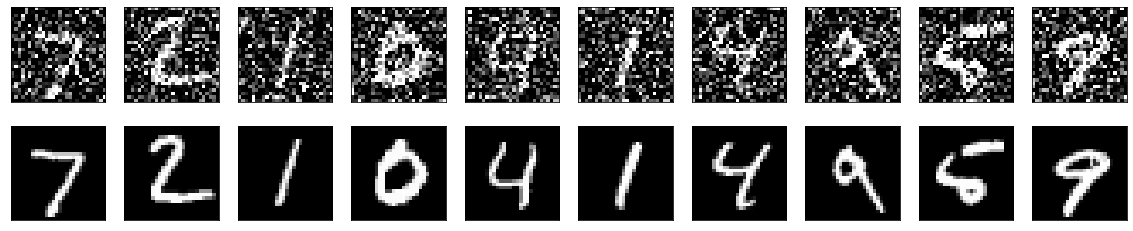

In [8]:
plot_numbers(x_test_noisy, x_test)

## Building autoencoder 

In [9]:
# v1
LATENT_SIZE = 32
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            Flatten(input_shape = (28, 28)),
            Dense(512),
            LR(),
            Dropout(0.5),
            Dense(256),
            LR(),
            Dropout(0.5),
            Dense(128),
            LR(),
            Dropout(0.5),
            Dense(64),
            LR(),
            Dropout(0.5),
            Dense(LATENT_SIZE),
            LR()
        ])
        self.decoder = tf.keras.Sequential([
            Dense(64, input_shape = (LATENT_SIZE,)),
            LR(),
            Dropout(0.5),
            Dense(128),
            LR(),
            Dropout(0.5),
            Dense(256),
            LR(),
            Dropout(0.5),
            Dense(512),
            LR(),
            Dropout(0.5),
            Dense(784),
            Activation("sigmoid"),
            Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder(LATENT_SIZE)
model.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [10]:
# v2
LATENT_SIZE = 32
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(784, activation='sigmoid'),
          layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder(LATENT_SIZE)
model.compile(optimizer='adam', loss=losses.MeanSquaredError())

### Autoencoder training

In [11]:
EPOCHS = 20
BATCH_SIZE = 128
# v2
from keras.callbacks import TensorBoard
model.fit(x_train_noisy, x_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0614 - val_loss: 0.0421
Epoch 2/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0364 - val_loss: 0.0315
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0292 - val_loss: 0.0267
Epoch 4/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0258 - val_loss: 0.0244
Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0240 - val_loss: 0.0230
Epoch 6/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0231 - val_loss: 0.0223
Epoch 7/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0224 - val_loss: 0.0219
Epoch 8/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0222 - val_loss: 0.0218
Epoch 9/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0221 - val_loss: 0.0217
Epoch 10/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0220 - val_loss: 0.0217

In [12]:
# Save and upload model
path = "model/autoencoder.pickle"
model.save(path)
model = tf.keras.models.load_model(path)

INFO:tensorflow:Assets written to: model/autoencoder.pickle\assets


### Results
Let's plot original, noisy and denoised images

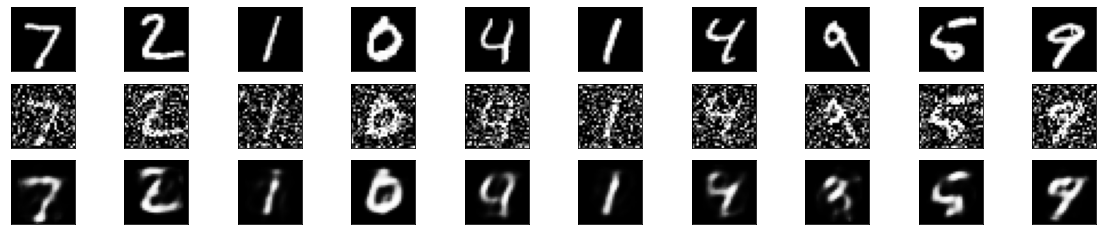

In [16]:
x_test_denoised = model.predict(x_test_noisy)
plot_numbers(x_test, x_test_noisy, x_test_denoised)

In [17]:
autoencoder = model

# Classification model 
Building a classification model based on original numbers. 

Steps:
- we built CNN and used the whole images as input vector
- we tranformed the output values with OneHotEncoder

In [18]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.layers import BatchNormalization

EPOCHS = 20
BATCH_SIZE = 128

In [19]:
x_train2 = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test2 = x_test.reshape((x_test.shape[0], 28, 28, 1))
x_test_noisy2 = x_test_noisy.reshape((x_test_noisy.shape[0], 28, 28, 1))
x_test_denoised2 = x_test_denoised.reshape((x_test_denoised.shape[0], 28, 28, 1))

In [20]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
y_train2 = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test2 = enc.transform(y_test.reshape(-1, 1)).toarray()

In [21]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    #opt = SGD(lr=0.01, momentum=0.9)
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model = define_model()
model.fit(x_train2, y_train2, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
469/469 [==============================] - 19s 39ms/step - loss: 0.2633 - accuracy: 0.9215
Epoch 2/20
469/469 [==============================] - 18s 38ms/step - loss: 0.1010 - accuracy: 0.9705
Epoch 3/20
469/469 [==============================] - 18s 38ms/step - loss: 0.0689 - accuracy: 0.9802
Epoch 4/20
469/469 [==============================] - 18s 38ms/step - loss: 0.0523 - accuracy: 0.9848
Epoch 5/20
469/469 [==============================] - 18s 38ms/step - loss: 0.0425 - accuracy: 0.9877
Epoch 6/20
469/469 [==============================] - 18s 37ms/step - loss: 0.0352 - accuracy: 0.9898
Epoch 7/20
469/469 [==============================] - 20s 42ms/step - loss: 0.0303 - accuracy: 0.99131s - l
Epoch 8/20
469/469 [==============================] - 19s 40ms/step - loss: 0.0258 - accuracy: 0.9926
Epoch 9/20
469/469 [==============================] - 18s 38ms/step - loss: 0.0216 - accuracy: 0.9941
Epoch 10/20
469/469 [==============================] - 18s 39ms/step - loss:

In [24]:
path = "model/classification.pickle"
model.save(path)
model = tf.keras.models.load_model(path)

INFO:tensorflow:Assets written to: model/classification.pickle\assets


## Model evaluation

In [25]:
import pandas as pd
df = pd.DataFrame(columns = ['accuracy', 'loss'])
loss, acc = model.evaluate(x_test2, y_test2, batch_size=BATCH_SIZE)
df.loc['original'] = [acc, loss]
loss, acc = model.evaluate(x_test_noisy2, y_test2, batch_size=BATCH_SIZE)
df.loc['noisy'] = [acc, loss]
loss, acc = model.evaluate(x_test_denoised2, y_test2, batch_size=BATCH_SIZE)
df.loc['denoised'] = [acc, loss]
#print("\nTest accuracy on original images: %.4f with loss: %.4f" % (acc, loss))

79/79 [==============================] - 1s 14ms/step - loss: 0.4200 - accuracy: 0.8894


In [26]:
df

,accuracy,loss
original,0.9876,0.043544
noisy,0.3182,5.796745
denoised,0.8894,0.419995


In [27]:
def plot_confusion_matrix(x, y_true):
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred, axis=1).T
    cf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf_matrix, annot=True,cmap='Blues', fmt='g')

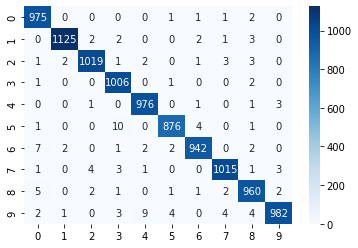

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = y_test2
y_true = np.argmax(y_true, axis=1).T

plot_confusion_matrix(x_test2, y_true)

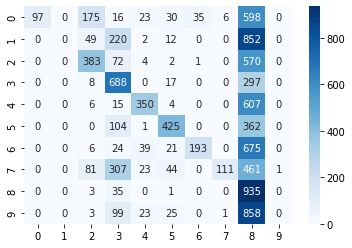

In [29]:
plot_confusion_matrix(x_test_noisy2, y_true)

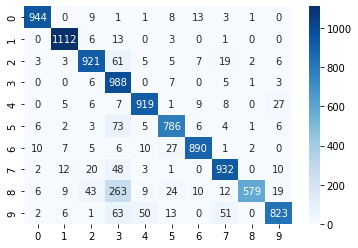

In [30]:
plot_confusion_matrix(x_test_denoised2, y_true)

## Conclusions
- based on confusion matrix and model evalution we can say that our classification model has great performance with 0.9876 accuracy for original images
- whereas this model works poorly on noisy images, it accuracy drops drastically to 0.3182. A lot of errors apear with numbers 3, 5, 8
- also, we can say that our autoencoder works great since after denoising classifcation model accuracy is 0.8894, that's quite acceptable